In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Data load**

In [ ]:
import numpy as np

# Load the full dataset
full_data_path = "/content/drive/MyDrive/KaggleData/ProcessedData/full_data.npy"
full_data = np.load(full_data_path, allow_pickle=True)

# Separate the images and labels
images = np.array([item[0] for item in full_data])
labels = np.array([item[1] for item in full_data])

print(f"Images shape: {images.shape}")  # This should show (7909, 224, 224, 3) or similar
print(f"Labels shape: {labels.shape}")  # This should show (7909,)

# You can now proceed with the rest of data preparation and modelling

Images shape: (7909, 224, 224, 3)
Labels shape: (7909,)


**Helping functions**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# **Model load**

**ResNet50 Load**

In [ ]:
# Define the path to the directory where the model and history file are saved
model_save_dir = "/content/drive/MyDrive/KaggleData/XVal"
model_path = os.path.join(model_save_dir, "resnet50.h5")


resnet50_model = load_model(model_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': tf.keras.metrics.AUC
})

# Print the model summary to check its architecture
try:
    resnet50_model.summary()
except AttributeError as e:
    print("Model is not loaded correctly:", e)

# Load the training history
history_path = os.path.join(model_save_dir, "resnet50_history.pkl")
if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print("Training history successfully loaded.")
else:
    print("History file does not exist.")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 16)          294928    
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 16)          64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 3, 3, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 batch_normalization_13 (Ba  (None, 3, 3, 32)         

In [ ]:
for layer in resnet50_model.layers:
    print(layer.name)


resnet50
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4


resnet50
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4
50/50 [==============================] - 6s 123ms/step


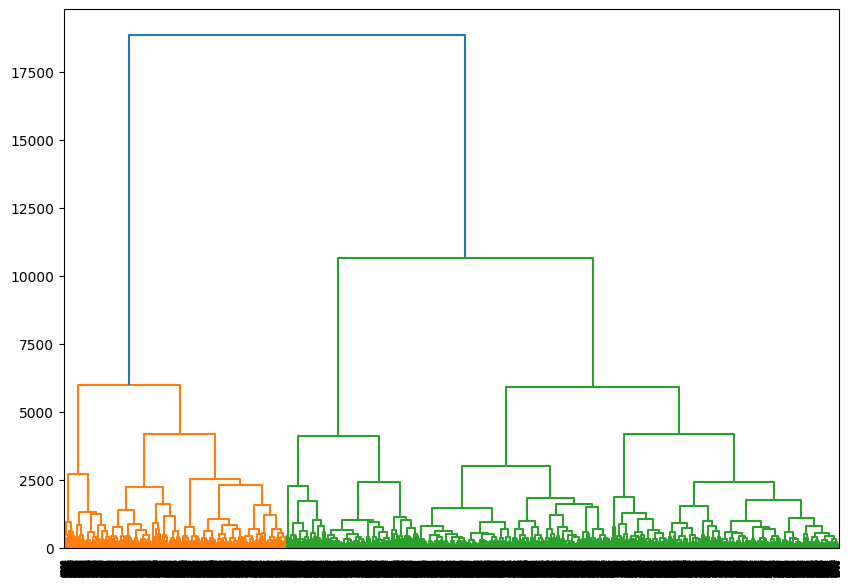

T-statistic: [  5.4755626 -18.95554   -88.02754    50.917572  -41.72419   -41.41322
 -16.128242  -81.19945   -42.740368  -46.24936   -13.922915  -36.644394
 -77.31205   -74.8091    -65.05208    17.333227   -1.6647444 -77.26782
 -88.14095   -30.449831  -34.707134  -61.40719   -44.478695  -80.1184
 -30.994871  -83.37989   -80.83681   -66.63979     0.783571  -60.86111
  55.069736  -83.493034 ], P-value: [4.5290285e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.9898438e-43 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 9.6013293e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.3332121e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from a model
def get_feature_extractor(base_model, layer_name):
    return Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def extract_features(model, data):
    return model.predict(data)

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Define the path to the directory where the model is saved
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "resnet50.h5")

# Load the trained model
resnet50_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Print layer names to identify the correct layer for feature extraction
for layer in resnet50_model.layers:
    print(layer.name)

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Use 'flatten_4' for feature extraction
layer_name = 'flatten_4'

# Feature extraction for analysis
feature_extractor = get_feature_extractor(resnet50_model, layer_name)
x_train_features = extract_features(feature_extractor, x_train)
x_val_features = extract_features(feature_extractor, x_val)

# Hierarchical clustering
plot_dendrogram(x_train_features)

# Statistical analysis
clustering = AgglomerativeClustering(n_clusters=2).fit(x_train_features)
perform_statistical_analysis(x_train_features, clustering.labels_)


198/198 [==============================] - 19s 94ms/step


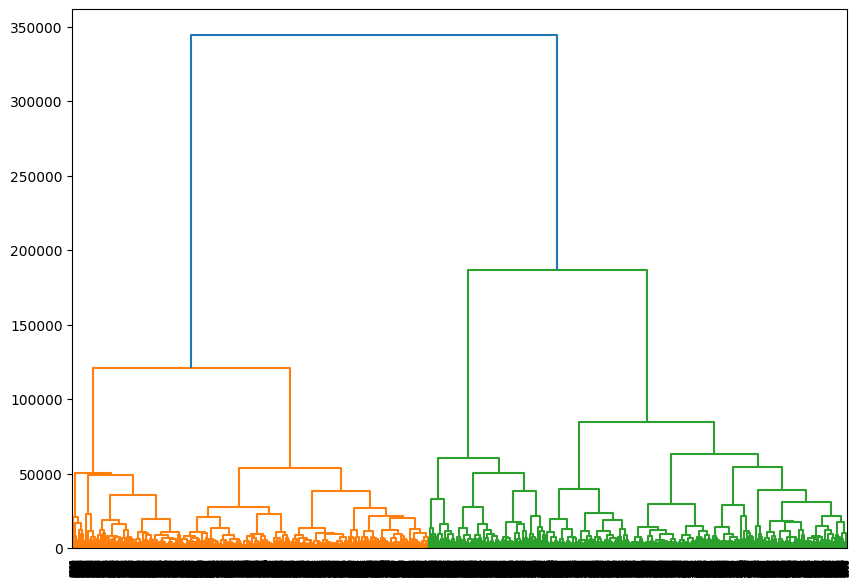

T-statistic: [         nan          nan  51.213314    60.37852             nan
          nan  58.39705     20.082605            nan   1.7655689
  47.16967             nan          nan -28.151665            nan
          nan          nan          nan  40.371174            nan
          nan  45.991947    74.509346    16.133482            nan
          nan  57.272057            nan          nan -32.952984
  -1.2440568           nan          nan          nan  35.57423
          nan          nan  58.77458     80.285225     9.850501
          nan  -1.0836308   62.904987            nan          nan
          nan  -1.293341            nan          nan          nan
  35.56277             nan          nan  58.278133    83.13701
   4.3796954           nan          nan  67.00729             nan
          nan          nan  -1.0836352           nan          nan
          nan  33.742996            nan          nan  62.50038
  86.11605      9.952888            nan          nan  63.788246
          nan

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import AUC
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from multiple layers of a model
def get_feature_extractor(base_model, layer_names):
    return [Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output) for layer_name in layer_names]

def extract_features(models, data):
    features = []
    for model in models:
        feature = model.predict(data)
        # Flatten the features if they are not already flattened
        if len(feature.shape) > 2:
            feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
    return features

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Load ResNet50 model
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "resnet50.h5")

resnet50_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Define the layers to extract features from
layer_names_resnet50 = ['conv2d_8', 'flatten_4']

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Feature extraction for analysis from multiple layers
feature_extractors_resnet50 = get_feature_extractor(resnet50_model, layer_names_resnet50)
x_train_features_resnet50_list = extract_features(feature_extractors_resnet50, x_train)

# Concatenate the features along the second axis (feature axis)
x_train_features_resnet50 = np.concatenate(x_train_features_resnet50_list, axis=1)

# Hierarchical clustering for ResNet50
plot_dendrogram(x_train_features_resnet50)

# Statistical analysis for ResNet50
clustering_resnet50 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_resnet50)
perform_statistical_analysis(x_train_features_resnet50, clustering_resnet50.labels_)



**EfficientNetB0 Load**

In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Define the path to the directory where the model and history file are saved
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_path = os.path.join(model_save_dir, "efnetB0_model.h5")


efnetB0_model = load_model(model_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': tf.keras.metrics.AUC
})

# Print the model summary to check its architecture
try:
    efnetB0_model.summary()
except AttributeError as e:
    print("Model is not loaded correctly:", e)

# Load the training history
history_path = os.path.join(model_save_dir, "efnetB0_model_history.pkl")
if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print("Training history successfully loaded.")
else:
    print("History file does not exist.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          147472    
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 batch_normalization_9 (Bat  (None, 3, 3, 32)         

In [ ]:
for layer in efnetB0_model.layers:
    print(layer.name)

densenet121
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4


efficientnetb0
conv2d_12
batch_normalization_12
max_pooling2d_12
conv2d_13
batch_normalization_13
max_pooling2d_13
flatten_6
dropout_6
dense_6
50/50 [==============================] - 4s 76ms/step


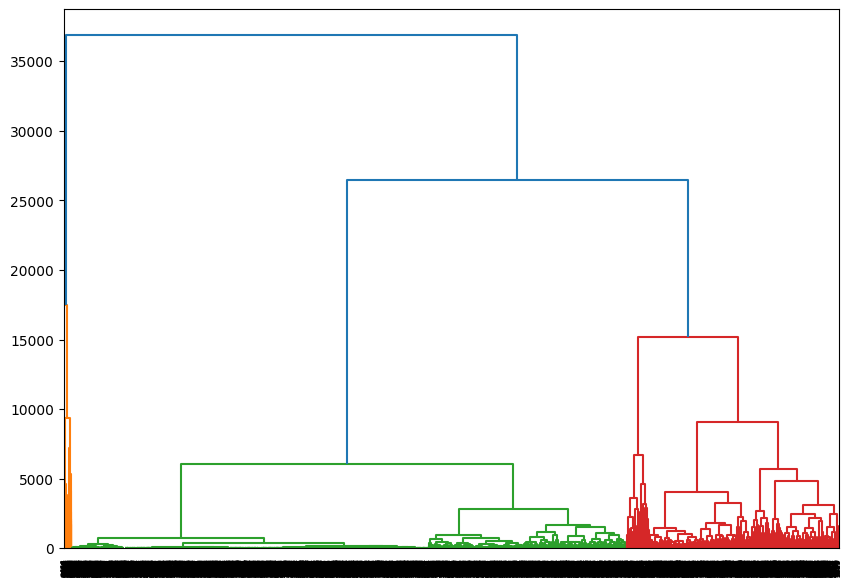

T-statistic: [-24.614737  -44.385044  -28.594639  -20.032543  -24.163792  -72.73008
 -45.921005  -64.464806  -38.719017  -36.9321      1.3074183 -38.679585
   1.4060117 -32.763035   -6.824521  -44.902195    1.0212501 -55.608253
 -50.837994  -27.545607  -63.237316  -51.029533  -48.02486   -10.614485
 -15.342747  -75.85445   -49.63824   -32.734566  -63.646145  -16.030975
 -61.682583   -9.66968  ], P-value: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.9111820e-01 0.0000000e+00 1.5976977e-01 0.0000000e+00 9.6426088e-12
 0.0000000e+00 3.0717501e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.2271090e-26 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.7534895e-22]


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from a model
def get_feature_extractor(base_model, layer_name):
    return Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def extract_features(model, data):
    return model.predict(data)

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Define the path to the directory where the model is saved
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "efnetB0.h5")

# Load the trained model
efnetB0_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Print layer names to identify the correct layer for feature extraction
for layer in efnetB0_model.layers:
    print(layer.name)

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Use 'flatten_6' for feature extraction
layer_name = 'flatten_6'

# Feature extraction for analysis
feature_extractor = get_feature_extractor(efnetB0_model, layer_name)
x_train_features = extract_features(feature_extractor, x_train)
x_val_features = extract_features(feature_extractor, x_val)

# Hierarchical clustering
plot_dendrogram(x_train_features)

# Statistical analysis
clustering = AgglomerativeClustering(n_clusters=2).fit(x_train_features)
perform_statistical_analysis(x_train_features, clustering.labels_)

198/198 [==============================] - 12s 52ms/step


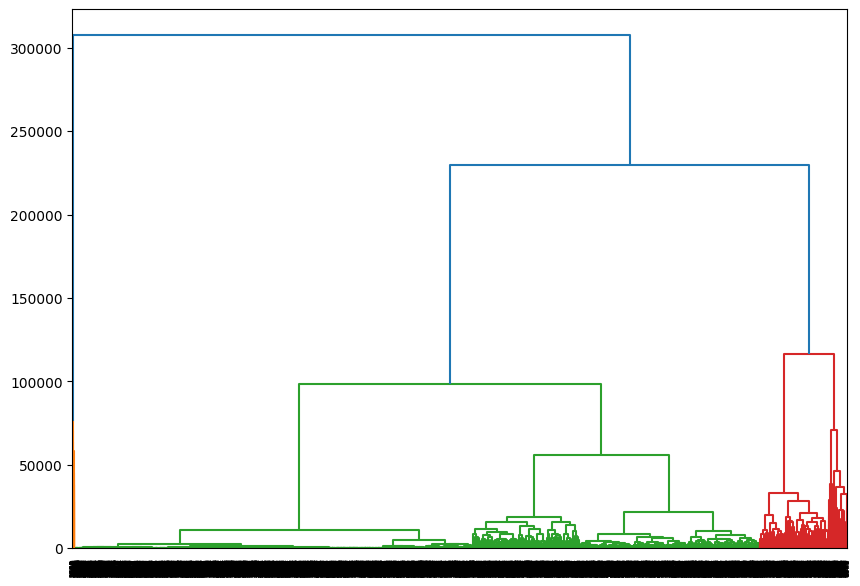

T-statistic: [-31.683      -42.460224   -13.40186     -1.5513947  -19.402927
 -31.78992    -19.438082   -30.501333   -14.307934   -30.737959
   0.42466807 -26.161495    -3.1763148  -25.309002   -33.940514
 -36.110752   -35.405815   -51.91365    -19.455969    -2.76269
 -22.414715   -42.977962   -13.963915   -27.696901   -19.637241
 -33.198624     0.4342692  -21.359203   -11.276354   -33.19992
 -34.476837   -38.7552     -36.692444   -58.12215    -25.892954
   0.6747306  -22.092247   -47.545654   -19.002607   -33.154106
 -23.457829   -39.750275    -5.040627   -30.915195   -13.0686245
 -43.880325   -38.262676   -41.662853   -34.13097    -60.436047
 -26.741226     0.5437373  -24.51617    -49.20403    -25.737482
 -36.762123   -24.105349   -42.425446   -10.326889   -36.670452
 -13.855329   -47.541584   -45.21774    -47.33622    -31.042124
 -61.553665   -31.792917    -1.002395   -29.213385   -47.927963
 -23.75998    -34.70921    -28.999916   -38.234066    -6.2213464
 -34.55476    -20.930614   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import AUC
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from multiple layers of a model
def get_feature_extractor(base_model, layer_names):
    return [Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output) for layer_name in layer_names]

def extract_features(models, data):
    features = []
    for model in models:
        feature = model.predict(data)
        # Flatten the features if they are not already flattened
        if len(feature.shape) > 2:
            feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
    return features

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Load ResNet50 model
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "efnetB0.h5")

efnetB0_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Define the layers to extract features from
layer_names_efnetB0 = ['conv2d_12', 'flatten_6']

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Feature extraction for analysis from multiple layers
feature_extractors_efnetB0 = get_feature_extractor(efnetB0_model, layer_names_efnetB0)
x_train_features_efnetB0_list = extract_features(feature_extractors_efnetB0, x_train)

# Concatenate the features along the second axis (feature axis)
x_train_features_efnetB0 = np.concatenate(x_train_features_efnetB0_list, axis=1)

# Hierarchical clustering for efnetB0
plot_dendrogram(x_train_features_efnetB0)

# Statistical analysis for efnetB0
clustering_efnetB0 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_efnetB0)
perform_statistical_analysis(x_train_features_efnetB0, clustering_efnetB0.labels_)




**DenseNet201 Load**

In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Define the path to the directory where the model and history file are saved
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_path = os.path.join(model_save_dir, "densenet201_model.h5")


densenet201_model = load_model(model_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': tf.keras.metrics.AUC
})

# Print the model summary to check its architecture
try:
    densenet201_model.summary()
except AttributeError as e:
    print("Model is not loaded correctly:", e)

# Load the training history
history_path = os.path.join(model_save_dir, "densenet201_model_history.pkl")
if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print("Training history successfully loaded.")
else:
    print("History file does not exist.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          276496    
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 16)          64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 batch_normalization_9 (Bat  (None, 3, 3, 32)         

In [ ]:
for layer in densenet201_model.layers:
    print(layer.name)

resnet50
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4
50/50 [==============================] - 12s 242ms/step


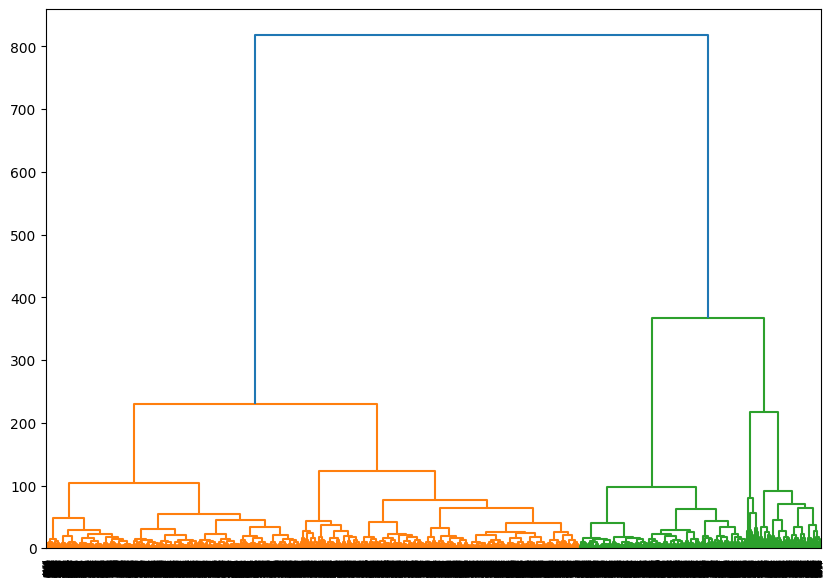

T-statistic: [-120.168015  -88.73317   106.96696    66.46147  -127.80133    89.609955
   84.47847   118.844734   92.67342    58.58471    85.20053   162.47466
   79.62797    99.06979   109.06527    57.666946  -53.503304 -107.75857
  -98.70771  -112.29131    93.57463  -114.33772  -107.443054   88.42896
 -102.32275    85.39727    76.31719    88.55805  -129.84334  -106.73939
   71.62172   103.71968 ], P-value: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Function to extract features from a model
def get_feature_extractor(base_model, layer_name):
    return Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

def extract_features(model, data):
    return model.predict(data)

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Define the path to the directory where the model is saved
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "densenet201_model.h5")

# Load the trained model
densenet201_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Print layer names to identify the correct layer for feature extraction
for layer in resnet50_model.layers:
    print(layer.name)

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Use 'flatten_4' for feature extraction
layer_name = 'flatten_4'

# Feature extraction for analysis
feature_extractor = get_feature_extractor(densenet201_model, layer_name)
x_train_features = extract_features(feature_extractor, x_train)
x_val_features = extract_features(feature_extractor, x_val)

# Hierarchical clustering
plot_dendrogram(x_train_features)

# Statistical analysis
clustering = AgglomerativeClustering(n_clusters=2).fit(x_train_features)
perform_statistical_analysis(x_train_features, clustering.labels_)

198/198 [==============================] - 30s 136ms/step


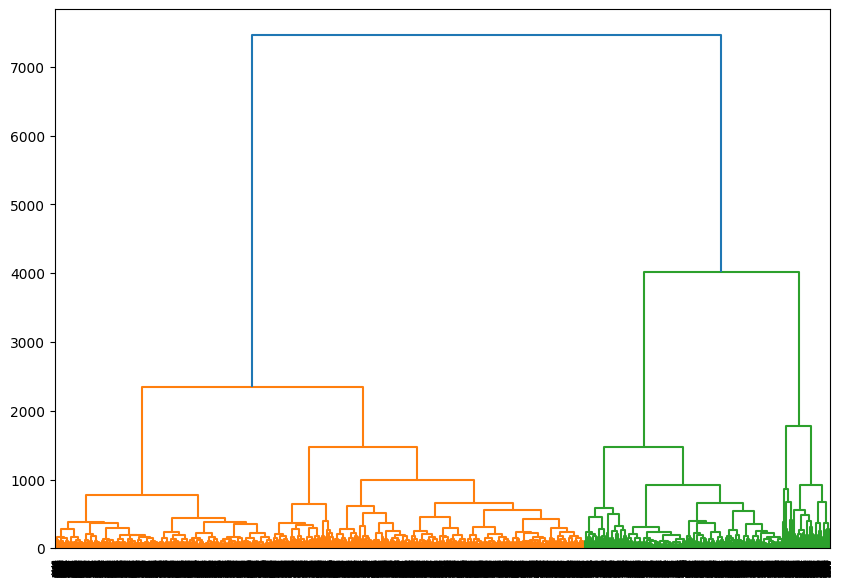

T-statistic: [  25.35685    -54.919224   -58.65203    -16.545895    66.89046
  -41.19895    -26.662235     8.08055     70.35768     46.40324
  -50.38216     72.022446   -35.739773   -80.428825   -32.31051
  -51.055347    23.707346   -73.005714   -63.81133    -39.135685
   84.45979    -62.43698    -55.794945    -2.8921025   92.74546
   46.08359    -75.88585     75.14174    -54.243862   -97.61613
  -42.098362   -82.86095     23.03377    -86.75632    -63.365143
  -65.370895    87.27436    -97.31679    -73.78456     -9.310612
   91.416466    57.381252   -89.77349     77.6138     -66.31884
 -105.32818    -55.889107   -69.954475    25.790773   -90.74111
  -61.897644   -70.812386    86.890816   -98.11645    -75.23636
   -9.37461     94.059364    55.315495   -87.83767     78.85279
  -76.09368   -107.0004     -61.207664   -83.1958      39.381065
  -44.140575   -71.70692    -24.487581    80.69418    -73.96684
  -25.581392   -15.091385    99.2627      45.403797   -68.26976
   78.07863    -30.8055

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import AUC
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from multiple layers of a model
def get_feature_extractor(base_model, layer_names):
    return [Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output) for layer_name in layer_names]

def extract_features(models, data):
    features = []
    for model in models:
        feature = model.predict(data)
        # Flatten the features if they are not already flattened
        if len(feature.shape) > 2:
            feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
    return features

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Function to perform statistical analysis between clusters
def perform_statistical_analysis(features, labels):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Load ResNet50 model
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path = os.path.join(model_save_dir, "densenet201_model.h5")

efnetB0_model = load_model(model_save_path, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Define the layers to extract features from
layer_names_densenet201 = ['conv2d_8', 'flatten_4']

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Feature extraction for analysis from multiple layers
feature_extractors_densenet201 = get_feature_extractor(densenet201_model, layer_names_densenet201)
x_train_features_densenet201_list = extract_features(feature_extractors_densenet201, x_train)

# Concatenate the features along the second axis (feature axis)
x_train_features_densenet201 = np.concatenate(x_train_features_densenet201_list, axis=1)

# Hierarchical clustering for DenseNet201
plot_dendrogram(x_train_features_densenet201)

# Statistical analysis for DenseNet201
clustering_densenet201 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_densenet201)
perform_statistical_analysis(x_train_features_densenet201, clustering_densenet201.labels_)

# **Extract Features from the Models: Interm. Layers**

# Extract Top Significant Features

In [ ]:
# Function to print the layer names in the model
def print_layer_names(model):
    for layer in model.layers:
        print(layer.name)

print("ResNet50 layers:")
print_layer_names(resnet50_model)

print("\nEfficientNetB0 layers:")
print_layer_names(efnetB0_model)

print("\nDenseNet201 layers:")
print_layer_names(densenet201_model)


ResNet50 layers:
resnet50
conv2d_6
batch_normalization_6
max_pooling2d_6
conv2d_7
batch_normalization_7
max_pooling2d_7
flatten_3
dropout_3
dense_3

EfficientNetB0 layers:
densenet121
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4

DenseNet201 layers:
densenet201
conv2d_8
batch_normalization_8
max_pooling2d_8
conv2d_9
batch_normalization_9
max_pooling2d_9
flatten_4
dropout_4
dense_4


198/198 [==============================] - 30s 138ms/step


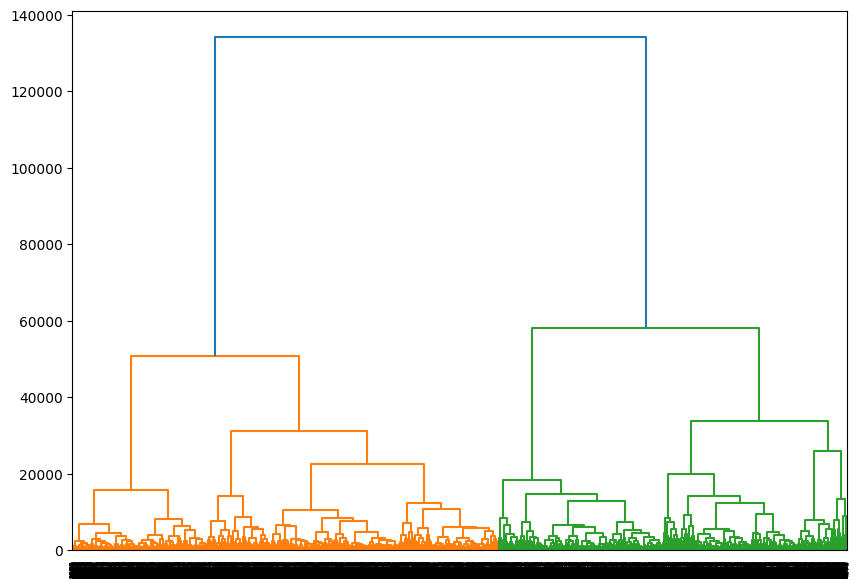

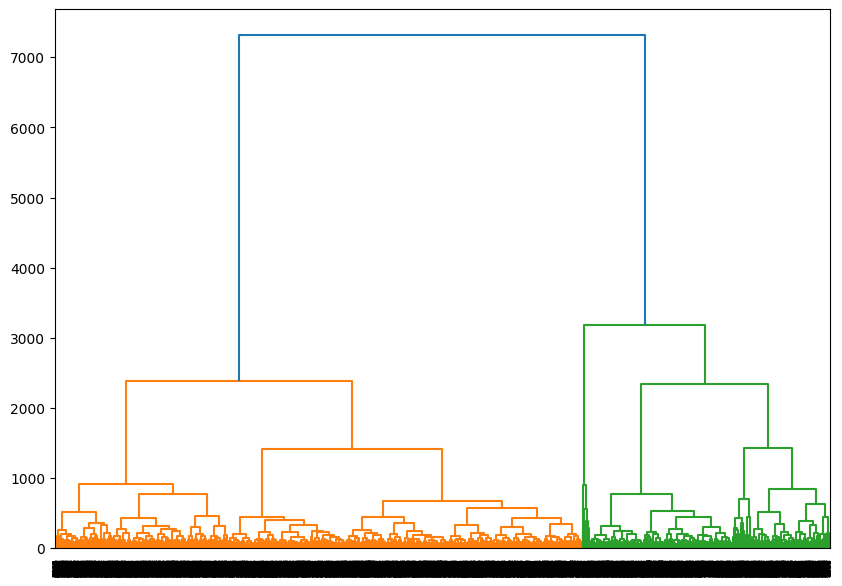

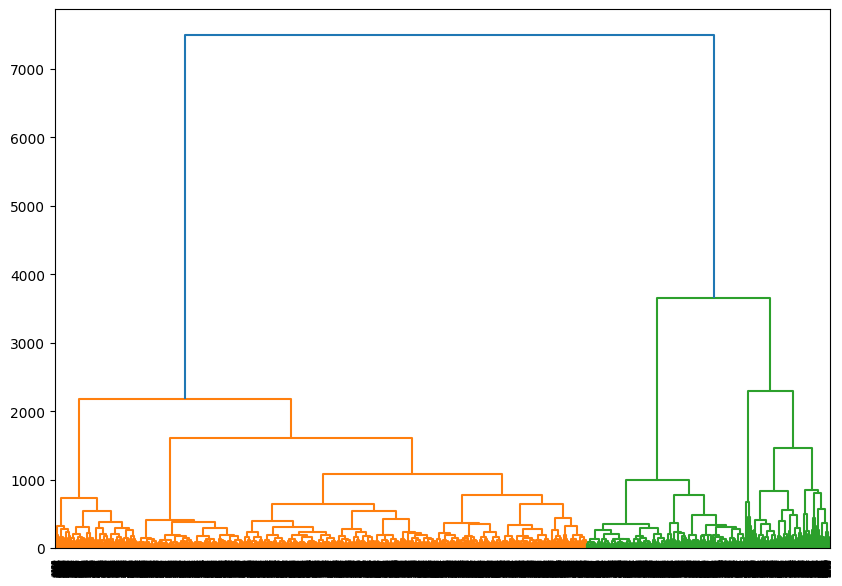

Results saved to /content/drive/MyDrive/KaggleData/TStatPValResults/ResNet50_t_stat_p_val.csv
Results saved to /content/drive/MyDrive/KaggleData/TStatPValResults/EfficientNetB0_t_stat_p_val.csv
Results saved to /content/drive/MyDrive/KaggleData/TStatPValResults/DenseNet201_t_stat_p_val.csv


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import AUC
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
import pandas as pd

# Custom Sensitivity and Specificity Metrics
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

# Custom Weighted Binary Crossentropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

# Function to extract features from multiple layers of a model
def get_feature_extractor(base_model, layer_names):
    return [Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output) for layer_name in layer_names]

def extract_features(models, data):
    features = []
    for model in models:
        feature = model.predict(data)
        # Flatten the features if they are not already flattened
        if len(feature.shape) > 2:
            feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
    return features

# Function to perform hierarchical clustering and plot dendrogram
def plot_dendrogram(features, method='ward'):
    linked = linkage(features, method=method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.show()

# Define the directory where you want to save the CSV files
csv_save_dir = "/content/drive/MyDrive/KaggleData/TStatPValResults"
os.makedirs(csv_save_dir, exist_ok=True)

# Function to perform statistical analysis between clusters and save results
def perform_statistical_analysis(features, labels, model_name):
    cluster_1_features = features[labels == 0]
    cluster_2_features = features[labels == 1]
    t_stat, p_val = ttest_ind(cluster_1_features, cluster_2_features)
    df = pd.DataFrame({'Feature': range(len(t_stat)), 'T-statistic': t_stat, 'P-value': p_val})
    csv_save_path = os.path.join(csv_save_dir, f'{model_name}_t_stat_p_val.csv')
    df.to_csv(csv_save_path, index=False)
    print(f"Results saved to {csv_save_path}")

# Load models
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
model_save_path_resnet50 = os.path.join(model_save_dir, "resnet50_model.h5")
resnet50_model = load_model(model_save_path_resnet50, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

model_save_path_efnetB0 = os.path.join(model_save_dir, "efnetB0_model.h5")
efnetB0_model = load_model(model_save_path_efnetB0, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

model_save_path_densenet201 = os.path.join(model_save_dir, "densenet201_model.h5")
densenet201_model = load_model(model_save_path_densenet201, custom_objects={
    '<lambda>': lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0),
    'sensitivity': sensitivity,
    'specificity': specificity,
    'AUC': AUC
})

# Define the layers to extract features from
layer_names_resnet50 = ['conv2d_6', 'conv2d_7', 'flatten_3']
layer_names_efnetB0 = ['conv2d_8', 'conv2d_9', 'flatten_4']
layer_names_densenet201 = ['conv2d_8', 'conv2d_9', 'flatten_4']

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Feature extraction for analysis from multiple layers
feature_extractors_resnet50 = get_feature_extractor(resnet50_model, layer_names_resnet50)
feature_extractors_efnetB0 = get_feature_extractor(efnetB0_model, layer_names_efnetB0)
feature_extractors_densenet201 = get_feature_extractor(densenet201_model, layer_names_densenet201)

x_train_features_resnet50_list = extract_features(feature_extractors_resnet50, x_train)
x_train_features_efnetB0_list = extract_features(feature_extractors_efnetB0, x_train)
x_train_features_densenet201_list = extract_features(feature_extractors_densenet201, x_train)

# Concatenate the features along the second axis (feature axis)
x_train_features_resnet50 = np.concatenate(x_train_features_resnet50_list, axis=1)
x_train_features_efnetB0 = np.concatenate(x_train_features_efnetB0_list, axis=1)
x_train_features_densenet201 = np.concatenate(x_train_features_densenet201_list, axis=1)

# Perform hierarchical clustering and plot dendrograms
clustering_resnet50 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_resnet50)
clustering_efnetB0 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_efnetB0)
clustering_densenet201 = AgglomerativeClustering(n_clusters=2).fit(x_train_features_densenet201)

plot_dendrogram(x_train_features_resnet50)
plot_dendrogram(x_train_features_efnetB0)
plot_dendrogram(x_train_features_densenet201)

# Perform statistical analysis and save results to CSV in the specified directory
perform_statistical_analysis(x_train_features_resnet50, clustering_resnet50.labels_, "ResNet50")
perform_statistical_analysis(x_train_features_efnetB0, clustering_efnetB0.labels_, "EfficientNetB0")
perform_statistical_analysis(x_train_features_densenet201, clustering_densenet201.labels_, "DenseNet201")


In [ ]:
# Define the threshold for statistical significance
p_value_threshold = 0.05

# Function to extract significant features based on t-statistics and p-values
def extract_significant_features(model_name, p_val_threshold):
    csv_path = os.path.join(csv_save_dir, f'{model_name}_t_stat_p_val.csv')
    df = pd.read_csv(csv_path)
    significant_features = df[df['P-value'] < p_val_threshold]
    return significant_features

# Extract significant features for each model
significant_features_resnet50 = extract_significant_features('ResNet50', p_value_threshold)
significant_features_efnetB0 = extract_significant_features('EfficientNetB0', p_value_threshold)
significant_features_densenet201 = extract_significant_features('DenseNet201', p_value_threshold)

# Add model name as a column to each dataframe
significant_features_resnet50['Model'] = 'ResNet50'
significant_features_efnetB0['Model'] = 'EfficientNetB0'
significant_features_densenet201['Model'] = 'DenseNet201'

# Concatenate the significant features into a single dataframe
summary_df = pd.concat([significant_features_resnet50, significant_features_efnetB0, significant_features_densenet201])

# Reorder columns for better readability
summary_df = summary_df[['Model', 'Feature', 'T-statistic', 'P-value']]

# Display the summary dataframe
print(summary_df)

# Save the summary dataframe as a CSV file
summary_csv_path = os.path.join(csv_save_dir, 'significant_features_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)
print(f"Summary CSV saved to {summary_csv_path}")

# Generate a LaTeX table from the summary dataframe
latex_table = summary_df.to_latex(index=False)

# Save the LaTeX table to a file
latex_file_path = os.path.join(csv_save_dir, 'significant_features_summary.tex')
with open(latex_file_path, 'w') as f:
    f.write(latex_table)
print(f"LaTeX table saved to {latex_file_path}")


            Model  Feature  T-statistic       P-value
1        ResNet50        1    62.094265  0.000000e+00
3        ResNet50        3    -8.755144  2.581949e-18
6        ResNet50        6    -2.461634  1.385707e-02
8        ResNet50        8     5.889849  4.064058e-09
9        ResNet50        9    11.459462  4.171986e-30
...           ...      ...          ...           ...
1099  DenseNet201     1099    89.199844  0.000000e+00
1100  DenseNet201     1100  -130.581310  0.000000e+00
1101  DenseNet201     1101  -108.621310  0.000000e+00
1102  DenseNet201     1102    71.489870  0.000000e+00
1103  DenseNet201     1103   102.723290  0.000000e+00

[2923 rows x 4 columns]
Summary CSV saved to /content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.csv
LaTeX table saved to /content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.tex


In [ ]:
# Define the threshold for statistical significance
p_value_threshold = 0.05

# Function to extract significant features based on t-statistics and p-values
def extract_significant_features(model_name, p_val_threshold):
    csv_path = os.path.join(csv_save_dir, f'{model_name}_t_stat_p_val.csv')
    df = pd.read_csv(csv_path)
    significant_features = df[df['P-value'] < p_val_threshold]
    return significant_features

# Extract significant features for each model
significant_features_resnet50 = extract_significant_features('ResNet50', p_value_threshold)
significant_features_efnetB0 = extract_significant_features('EfficientNetB0', p_value_threshold)
significant_features_densenet201 = extract_significant_features('DenseNet201', p_value_threshold)

# Add model name as a column to each dataframe
significant_features_resnet50['Model'] = 'ResNet50'
significant_features_efnetB0['Model'] = 'EfficientNetB0'
significant_features_densenet201['Model'] = 'DenseNet201'

# Concatenate the significant features into a single dataframe
summary_df = pd.concat([significant_features_resnet50, significant_features_efnetB0, significant_features_densenet201])

# Reorder columns for better readability
summary_df = summary_df[['Model', 'Feature', 'T-statistic', 'P-value']]

# Display the summary dataframe
print(summary_df)

# Save the summary dataframe as a CSV file
summary_csv_path = os.path.join(csv_save_dir, 'significant_features_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)
print(f"Summary CSV saved to {summary_csv_path}")

# Generate a LaTeX table from the summary dataframe
latex_table = summary_df.to_latex(index=False)

# Save the LaTeX table to a file
latex_file_path = os.path.join(csv_save_dir, 'significant_features_summary.tex')
with open(latex_file_path, 'w') as f:
    f.write(latex_table)
print(f"LaTeX table saved to {latex_file_path}")

            Model  Feature  T-statistic       P-value
1        ResNet50        1    62.094265  0.000000e+00
3        ResNet50        3    -8.755144  2.581949e-18
6        ResNet50        6    -2.461634  1.385707e-02
8        ResNet50        8     5.889849  4.064058e-09
9        ResNet50        9    11.459462  4.171986e-30
...           ...      ...          ...           ...
1099  DenseNet201     1099    89.199844  0.000000e+00
1100  DenseNet201     1100  -130.581310  0.000000e+00
1101  DenseNet201     1101  -108.621310  0.000000e+00
1102  DenseNet201     1102    71.489870  0.000000e+00
1103  DenseNet201     1103   102.723290  0.000000e+00

[2923 rows x 4 columns]
Summary CSV saved to /content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.csv
LaTeX table saved to /content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.tex


In [ ]:
import pandas as pd

# Load the summary CSV file
summary_csv_path = "/content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.csv"
summary_df = pd.read_csv(summary_csv_path)

# Display the summary dataframe
print(summary_df)


            Model  Feature  T-statistic       P-value
0        ResNet50        1    62.094265  0.000000e+00
1        ResNet50        3    -8.755144  2.581949e-18
2        ResNet50        6    -2.461634  1.385707e-02
3        ResNet50        8     5.889849  4.064058e-09
4        ResNet50        9    11.459462  4.171986e-30
...           ...      ...          ...           ...
2918  DenseNet201     1099    89.199844  0.000000e+00
2919  DenseNet201     1100  -130.581310  0.000000e+00
2920  DenseNet201     1101  -108.621310  0.000000e+00
2921  DenseNet201     1102    71.489870  0.000000e+00
2922  DenseNet201     1103   102.723290  0.000000e+00

[2923 rows x 4 columns]


In [ ]:
# # Load and print the LaTeX table
# latex_file_path = "/content/drive/MyDrive/KaggleData/TStatPValResults/significant_features_summary.tex"
# with open(latex_file_path, 'r') as f:
#     latex_table = f.read()

# print(latex_table)


In [ ]:
# from IPython.display import display, Latex

# # Display the LaTeX table in the notebook
# display(Latex(latex_table))


# Calculate basic descriptive statistics for each model to understand the distribution of T-statistics and P-values.

In [ ]:
# Calculate descriptive statistics
desc_stats = summary_df.groupby('Model')[['T-statistic', 'P-value']].describe()
print(desc_stats)


               T-statistic                                               \
                     count       mean        std         min        25%   
Model                                                                     
DenseNet201         1101.0  -6.632390  70.956326 -135.126020 -69.397890   
EfficientNetB0      1010.0   2.641084  70.131613 -114.354485 -63.630332   
ResNet50             812.0  52.538055  35.297665  -58.967503  23.206359   

                                                 P-value                      \
                      50%        75%         max   count      mean       std   
Model                                                                          
DenseNet201    -23.319643  62.652250  166.809590  1101.0  0.000042  0.000803   
EfficientNetB0  -9.696450  76.827352  118.268140  1010.0  0.000222  0.002893   
ResNet50        57.818428  81.457067  114.437225   812.0  0.000913  0.005370   

                                              
                min  

# filter the features with very low P-values (e.g., P-value < 0.001) for more focused analysis.

In [ ]:
# Filter significant features with P-value < 0.001
significant_features = summary_df[summary_df['P-value'] < 0.001]
print(significant_features)


            Model  Feature  T-statistic       P-value
0        ResNet50        1    62.094265  0.000000e+00
1        ResNet50        3    -8.755144  2.581949e-18
3        ResNet50        8     5.889849  4.064058e-09
4        ResNet50        9    11.459462  4.171986e-30
5        ResNet50       12    56.957230  0.000000e+00
...           ...      ...          ...           ...
2918  DenseNet201     1099    89.199844  0.000000e+00
2919  DenseNet201     1100  -130.581310  0.000000e+00
2920  DenseNet201     1101  -108.621310  0.000000e+00
2921  DenseNet201     1102    71.489870  0.000000e+00
2922  DenseNet201     1103   102.723290  0.000000e+00

[2869 rows x 4 columns]


# Visualise the distributions of T-statistics and P-values for each model using histograms or/and box plots.

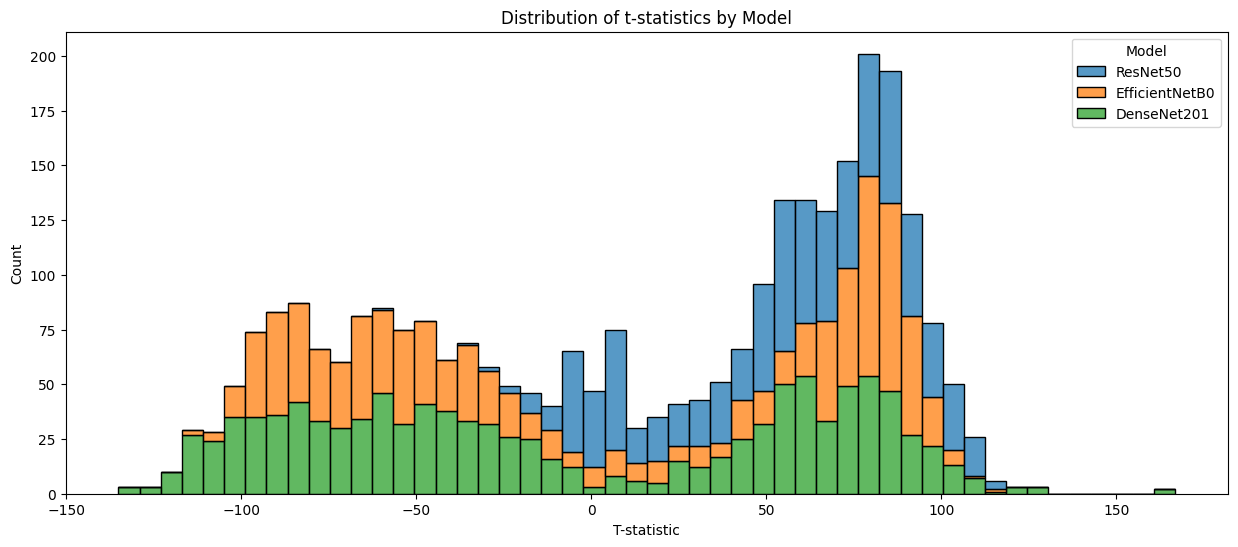

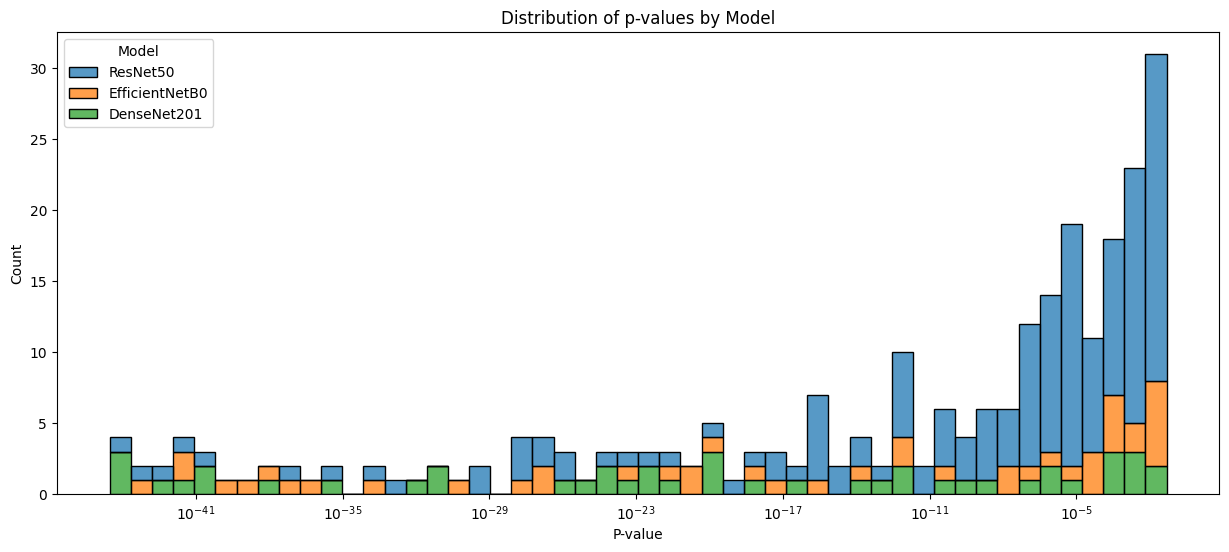

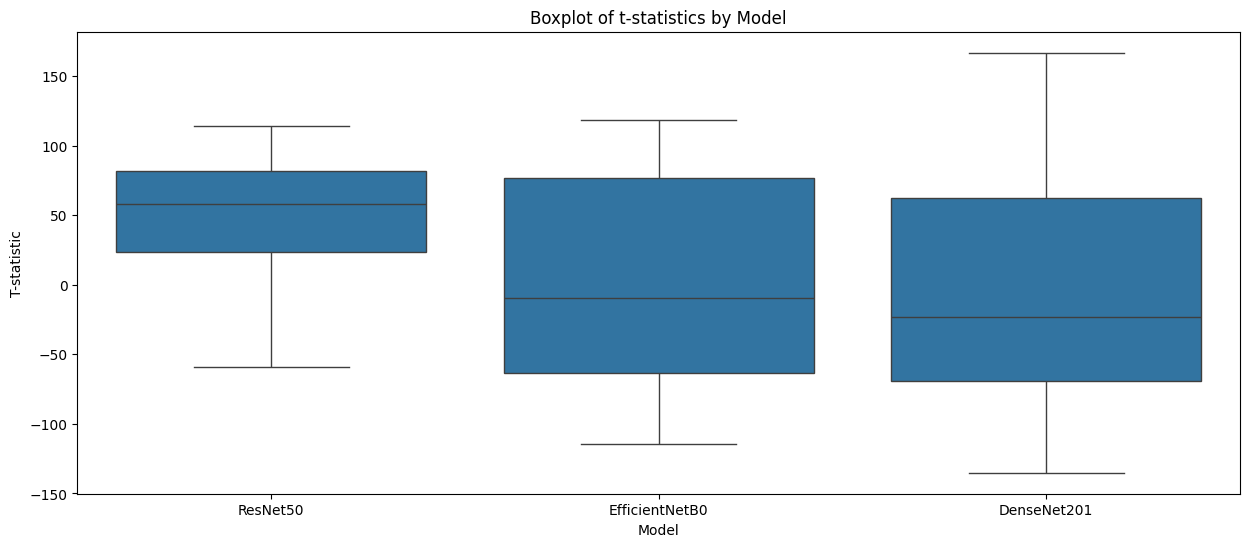

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


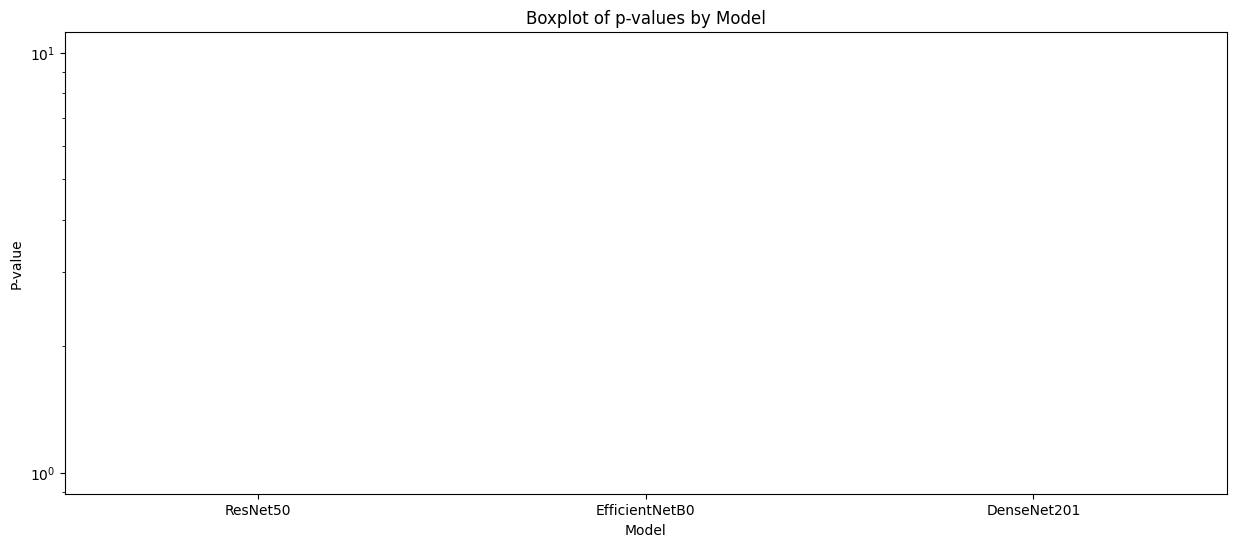

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms
plt.figure(figsize=(15, 6))
sns.histplot(data=summary_df, x='T-statistic', hue='Model', multiple='stack', bins=50)
plt.title('Distribution of t-statistics by Model')
plt.show()

plt.figure(figsize=(15, 6))
sns.histplot(data=summary_df, x='P-value', hue='Model', multiple='stack', bins=50, log_scale=True)
plt.title('Distribution of p-values by Model')
plt.show()

# Box plots
plt.figure(figsize=(15, 6))
sns.boxplot(data=summary_df, x='Model', y='T-statistic')
plt.title('Boxplot of t-statistics by Model')
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(data=summary_df, x='Model', y='P-value', log_scale=True)
plt.title('Boxplot of p-values by Model')
plt.show()


# Identify the top features for each model based on T-statistics.

In [ ]:
# Top features based on T-statistics for each model
top_features = summary_df.loc[summary_df.groupby('Model')['T-statistic'].idxmax()]
print(top_features)


               Model  Feature  T-statistic  P-value
2902     DenseNet201     1083   166.809590      0.0
1697  EfficientNetB0      977   118.268140      0.0
446         ResNet50      620   114.437225      0.0


**Analyze the correlation between the features. This can help understand if certain features are correlated across models.**

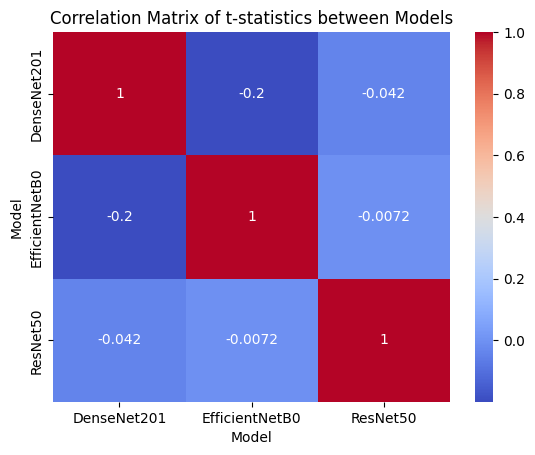

In [ ]:
# Correlation analysis between features
correlation_matrix = summary_df.pivot(index='Feature', columns='Model', values='T-statistic').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of t-statistics between Models')
plt.show()


# Cluster the features based on T-statistics to see if there are any natural groupings.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


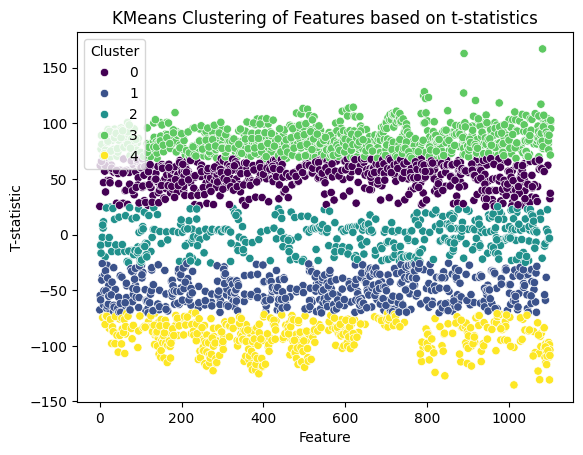

In [ ]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
num_clusters = 5  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters)
summary_df['Cluster'] = kmeans.fit_predict(summary_df[['T-statistic']])

# Visualize clusters
sns.scatterplot(data=summary_df, x='Feature', y='T-statistic', hue='Cluster', palette='viridis')
plt.title('KMeans Clustering of Features based on t-statistics')
plt.show()


In [ ]:
# Save significant features to CSV
significant_features.to_csv('/content/drive/MyDrive/KaggleData/significant_features_filtered.csv', index=False)

# Save descriptive statistics to CSV
desc_stats.to_csv('/content/drive/MyDrive/KaggleData/desc_stats.csv')


# Create a New Dataframe with the Top Features

In [ ]:
import pandas as pd

# Manually create a dataframe with the top features
top_features_data = {
    'Model': ['DenseNet201', 'EfficientNetB0', 'ResNet50'],
    'Feature': [1083, 977, 620],
    'T-statistic': [166.809590, 118.268140, 114.437225],
    'P-value': [0.0, 0.0, 0.0]
}

top_features_df = pd.DataFrame(top_features_data)
print(top_features_df)


            Model  Feature  T-statistic  P-value
0     DenseNet201     1083   166.809590      0.0
1  EfficientNetB0      977   118.268140      0.0
2        ResNet50      620   114.437225      0.0


# Generate a LaTeX Table from the Summary Dataframe

In [ ]:
# Generate a LaTeX table from the top features dataframe
latex_table = top_features_df.to_latex(index=False)

# Save the LaTeX table to a file
latex_file_path = "/content/drive/MyDrive/KaggleData/top_features_summary.tex"
with open(latex_file_path, 'w') as f:
    f.write(latex_table)

print(f"LaTeX table saved to {latex_file_path}")

# Display the LaTeX table in the notebook (if using a notebook environment)
from IPython.display import display, Latex
display(Latex(latex_table))


LaTeX table saved to /content/drive/MyDrive/KaggleData/top_features_summary.tex


<IPython.core.display.Latex object>

By analyzing these clusters, WE can identify patterns and common characteristics among the features, helping to understand which features are most important and how they contribute to the model's performance.

      Model  Feature  T-statistic       P-value  Cluster
0  ResNet50        1    62.094265  0.000000e+00        0
1  ResNet50        3    -8.755144  2.581949e-18        2
3  ResNet50        8     5.889849  4.064058e-09        2
4  ResNet50        9    11.459462  4.171986e-30        2
5  ResNet50       12    56.957230  0.000000e+00        0
   Cluster  T_stat_mean  T_stat_std  T_stat_min  T_stat_25  T_stat_50  \
0        0    52.196850   11.492205   25.322382  44.048025  54.724369   
1        1   -49.643631   12.557775  -70.569810 -60.579885 -50.318305   
2        2    -1.705377   14.695414  -25.741505 -14.877956  -3.848361   
3        3    85.380129   11.314633   68.849550  77.246062  83.617020   
4        4   -91.361252   12.901685 -135.126020 -99.295333 -89.569525   

   T_stat_75  T_stat_max  P_value_mean  P_value_std  P_value_min  P_value_25  \
0  61.720116   68.772840      0.000000     0.000000          0.0         0.0   
1 -38.596128  -26.023668      0.000000     0.000000        

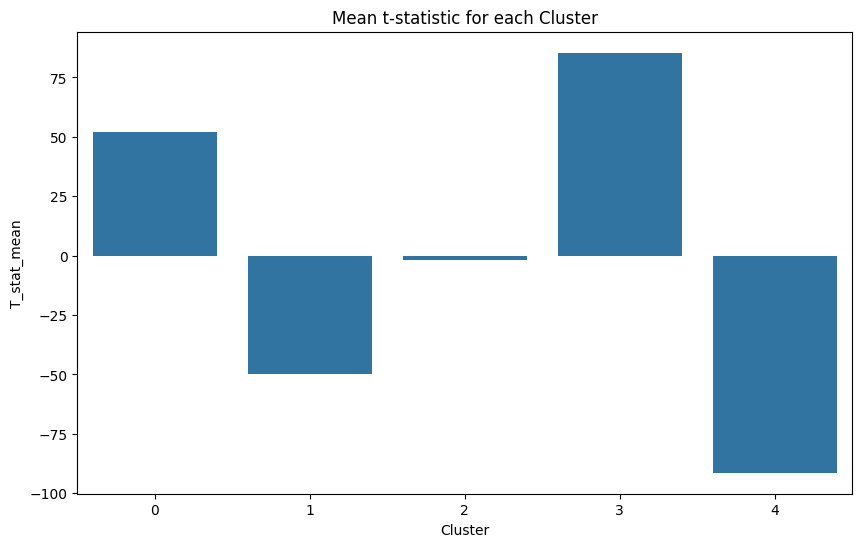

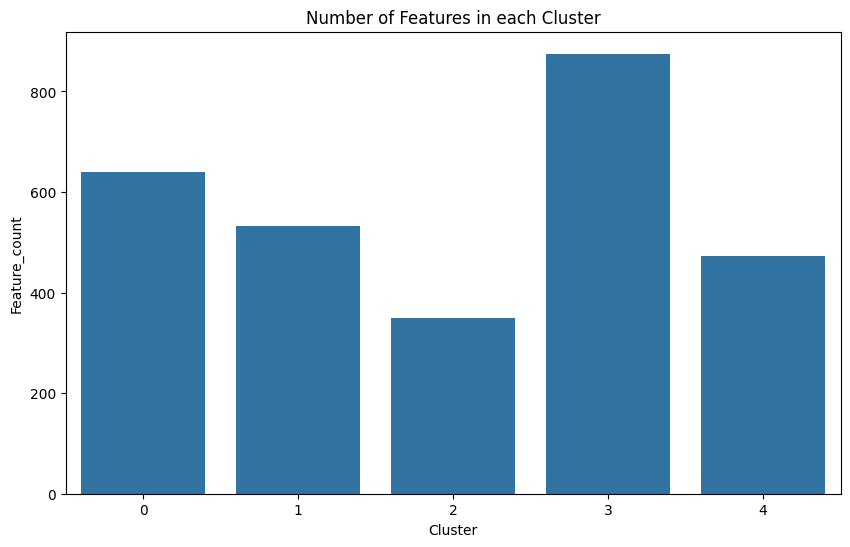

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

# Assuming 'significant_features' dataframe contains the features and their T-statistics and P-values
# Ensure the dataframe is loaded correctly
# significant_features = pd.read_csv('/path/to/significant_features.csv')  # Adjust the path as needed

# Perform KMeans clustering
num_clusters = 5  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
significant_features = significant_features.copy()  # Ensure we modify a copy
significant_features['Cluster'] = kmeans.fit_predict(significant_features[['T-statistic']])

# Display the first few rows of the dataframe to confirm the 'Cluster' column is added
print(significant_features.head())

# Define custom functions for calculating percentiles
def percentile_25(x):
    return x.quantile(0.25)

def percentile_50(x):
    return x.quantile(0.50)

def percentile_75(x):
    return x.quantile(0.75)

# Summarize clusters with custom percentile functions
cluster_summary = significant_features.groupby('Cluster').agg(
    T_stat_mean=('T-statistic', 'mean'),
    T_stat_std=('T-statistic', 'std'),
    T_stat_min=('T-statistic', 'min'),
    T_stat_25=('T-statistic', percentile_25),
    T_stat_50=('T-statistic', percentile_50),
    T_stat_75=('T-statistic', percentile_75),
    T_stat_max=('T-statistic', 'max'),
    P_value_mean=('P-value', 'mean'),
    P_value_std=('P-value', 'std'),
    P_value_min=('P-value', 'min'),
    P_value_25=('P-value', percentile_25),
    P_value_50=('P-value', percentile_50),
    P_value_75=('P-value', percentile_75),
    P_value_max=('P-value', 'max'),
    Feature_count=('Feature', 'count')
).reset_index()

print(cluster_summary)

# Save the cluster summary to a CSV file
cluster_summary_csv_path = '/content/drive/MyDrive/KaggleData/cluster_summary.csv'
cluster_summary.to_csv(cluster_summary_csv_path, index=False)
print(f"Cluster summary CSV saved to {cluster_summary_csv_path}")

# Visualize the cluster summary
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the mean T-statistic for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='T_stat_mean', data=cluster_summary)
plt.title('Mean t-statistic for each Cluster')
plt.show()

# Plot the number of features in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Feature_count', data=cluster_summary)
plt.title('Number of Features in each Cluster')
plt.show()



The visualizations show the distribution of features and their T-statistics across different clusters.

Interpretation of Cluster Summaries
Cluster 0: This cluster has a high mean T-statistic, indicating that features in this cluster are generally strong predictors.

Cluster 1: Feature Count: 532
Features in this cluster have negative T-statistics, indicating they might be inversely related to the target.

Cluster 2: This cluster has a mean T-statistic close to zero, suggesting these features are less significant.

Cluster 3: has the highest mean T-statistic, indicating very strong predictors.
Cluster 4: Features in this cluster have very negative T-statistics, suggesting they are strong negative predictors.

Steps for Further Analysis
Investigate High-Impact Clusters:

Focus on clusters with high absolute mean T-statistics (Clusters 0, 1, 3, 4) to understand what features contribute to strong predictions.
Analyze Low-Impact Clusters:
Investigate Cluster 2 to understand why these features have little impact.
Compare Feature Characteristics:

Compare feature characteristics within and across clusters to identify common patterns.

   Cluster  T_stat_mean  T_stat_std  T_stat_min  T_stat_25  T_stat_50  \
0        0    52.196850   11.492205   25.322382  44.048025  54.724369   
1        1   -49.643631   12.557775  -70.569810 -60.579885 -50.318305   
2        2    -1.705377   14.695414  -25.741505 -14.877956  -3.848361   
3        3    85.380129   11.314633   68.849550  77.246062  83.617020   
4        4   -91.361252   12.901685 -135.126020 -99.295333 -89.569525   

   T_stat_75  T_stat_max  P_value_mean  P_value_std  P_value_min  P_value_25  \
0  61.720116   68.772840      0.000000     0.000000          0.0         0.0   
1 -38.596128  -26.023668      0.000000     0.000000          0.0         0.0   
2   9.444851   25.028412      0.000022     0.000098          0.0         0.0   
3  91.513177  166.809590      0.000000     0.000000          0.0         0.0   
4 -81.706238  -70.729160      0.000000     0.000000          0.0         0.0   

     P_value_50    P_value_75  P_value_max  Feature_count  
0  0.000000e+00  0.0

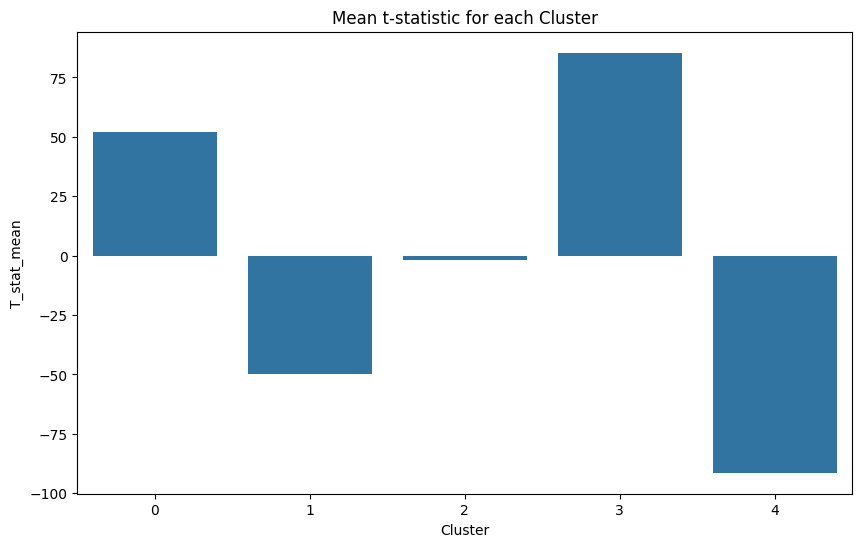

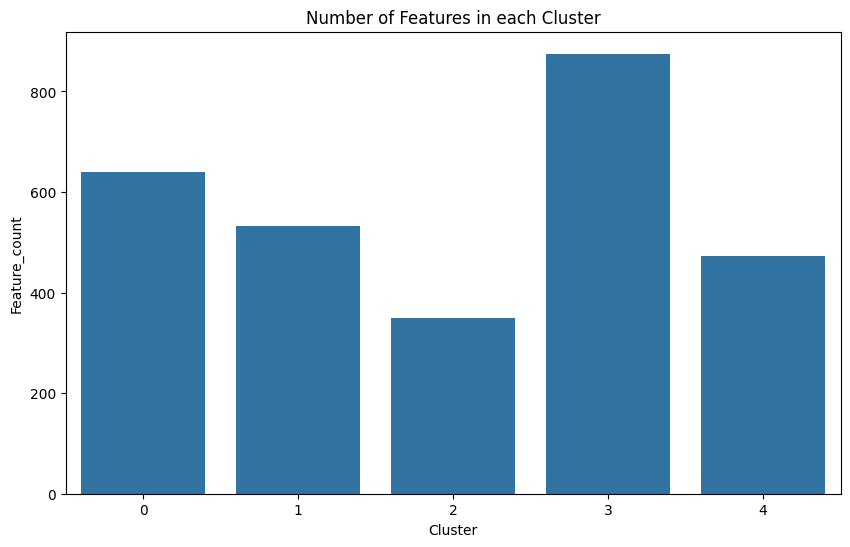

      Model  Feature  T-statistic  P-value  Cluster
0  ResNet50        1    62.094265      0.0        0
5  ResNet50       12    56.957230      0.0        0
7  ResNet50       14    38.279636      0.0        0
8  ResNet50       15   -27.998959      0.0        1
9  ResNet50       17    67.642990      0.0        0


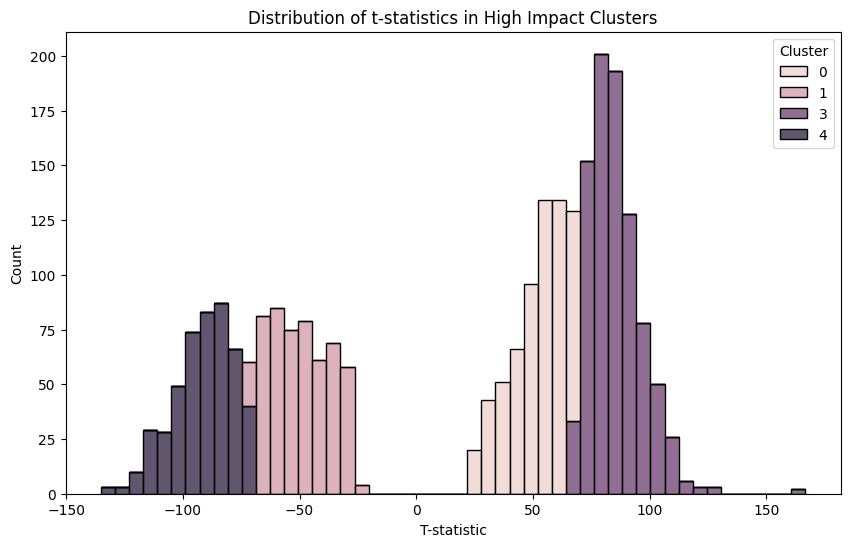

In [ ]:
import pandas as pd

# Assuming 'significant_features' dataframe contains the clustering results
# Display the cluster summary
print(cluster_summary)

# Save the cluster summary to a CSV file
cluster_summary_csv_path = '/content/drive/MyDrive/KaggleData/cluster_summary.csv'
cluster_summary.to_csv(cluster_summary_csv_path, index=False)
print(f"Cluster summary CSV saved to {cluster_summary_csv_path}")

# Visualize the cluster summary
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the mean T-statistic for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='T_stat_mean', data=cluster_summary)
plt.title('Mean t-statistic for each Cluster')
plt.show()

# Plot the number of features in each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Feature_count', data=cluster_summary)
plt.title('Number of Features in each Cluster')
plt.show()

# Further investigation of clusters with high absolute mean T-statistics
high_impact_clusters = significant_features[significant_features['Cluster'].isin([0, 1, 3, 4])]
print(high_impact_clusters.head())

# Visualize distribution of T-statistics in high impact clusters
plt.figure(figsize=(10, 6))
sns.histplot(data=high_impact_clusters, x='T-statistic', hue='Cluster', multiple='stack', bins=50)
plt.title('Distribution of t-statistics in High Impact Clusters')
plt.show()


In [ ]:
# Check the unique models in the significant_features dataframe
print("Unique models in significant_features:")
print(significant_features['Model'].unique())

# Check the number of features from each model
model_counts = significant_features['Model'].value_counts()
print("Number of features from each model:")
print(model_counts)


Unique models in significant_features:
['ResNet50' 'EfficientNetB0' 'DenseNet201']
Number of features from each model:
Model
DenseNet201       1096
EfficientNetB0    1002
ResNet50           771
Name: count, dtype: int64


Distribution of features across clusters and models:
Model    DenseNet201  EfficientNetB0  ResNet50
Cluster                                       
0              225.0           121.0     294.0
1              271.0           257.0       4.0
2               99.0            88.0     163.0
3              234.0           331.0     310.0
4              267.0           205.0       0.0


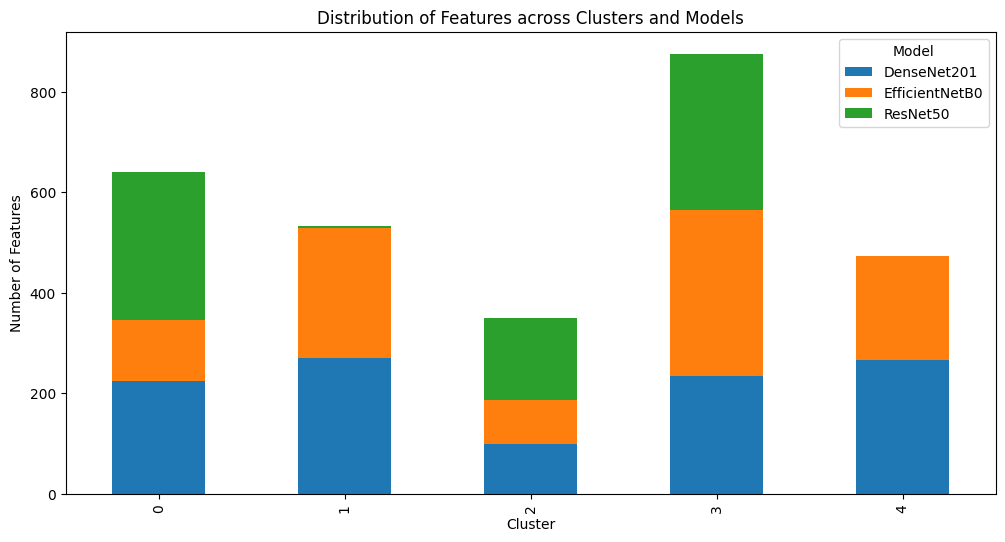

In [ ]:
from sklearn.cluster import KMeans

# Re-run clustering on the significant features
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
significant_features['Cluster'] = kmeans.fit_predict(significant_features[['T-statistic']])

# Check the distribution of features across clusters and models
cluster_model_distribution = significant_features.groupby(['Cluster', 'Model']).size().unstack().fillna(0)
print("Distribution of features across clusters and models:")
print(cluster_model_distribution)

# Visualize the distribution of features across clusters and models
cluster_model_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Features across Clusters and Models')
plt.xlabel('Cluster')
plt.ylabel('Number of Features')
plt.show()


      Model  Feature  T-statistic       P-value  Cluster
0  ResNet50        1    62.094265  0.000000e+00        0
1  ResNet50        3    -8.755144  2.581949e-18        2
3  ResNet50        8     5.889849  4.064058e-09        2
4  ResNet50        9    11.459462  4.171986e-30        2
5  ResNet50       12    56.957230  0.000000e+00        0
Distribution of features across clusters and models after re-clustering:
Model    DenseNet201  EfficientNetB0  ResNet50
Cluster                                       
0              225.0           121.0     294.0
1              271.0           257.0       4.0
2               99.0            88.0     163.0
3              234.0           331.0     310.0
4              267.0           205.0       0.0


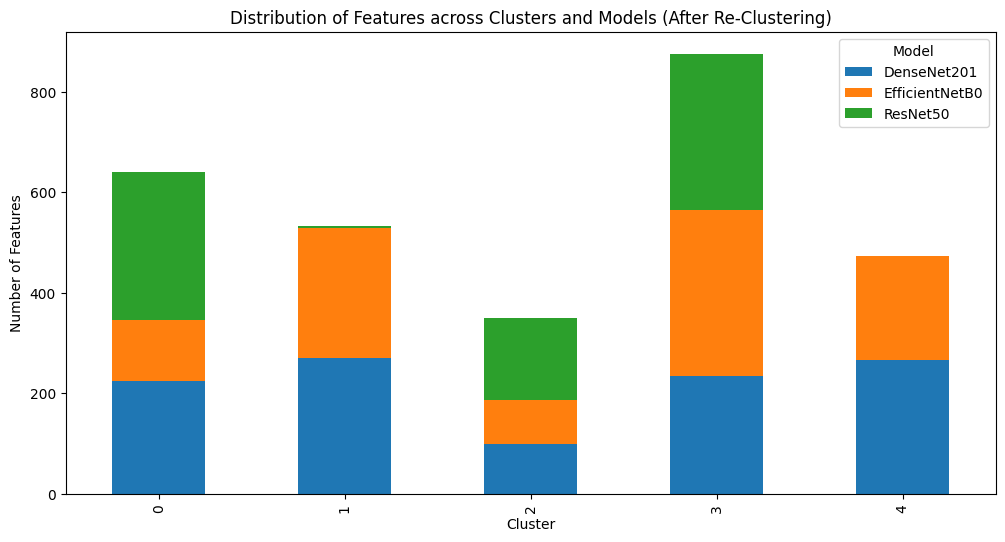

      Model  Feature  T-statistic  P-value  Cluster
0  ResNet50        1    62.094265      0.0        0
5  ResNet50       12    56.957230      0.0        0
7  ResNet50       14    38.279636      0.0        0
8  ResNet50       15   -27.998959      0.0        1
9  ResNet50       17    67.642990      0.0        0


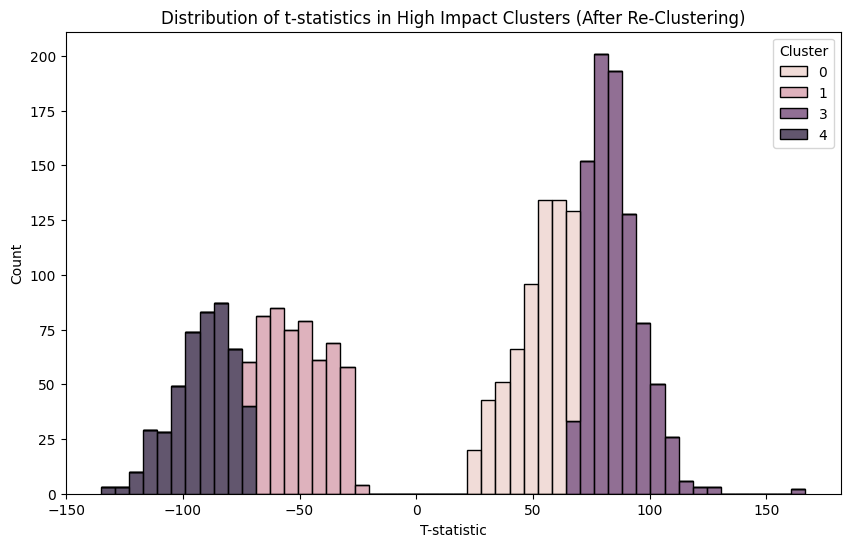

In [ ]:
# Ensure the clustering process includes features from all models
from sklearn.cluster import KMeans

# Re-run clustering on the significant features
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
significant_features['Cluster'] = kmeans.fit_predict(significant_features[['T-statistic']])

# Check the first few rows to verify clustering
print(significant_features.head())

# Check the distribution of features across clusters and models again
cluster_model_distribution = significant_features.groupby(['Cluster', 'Model']).size().unstack().fillna(0)
print("Distribution of features across clusters and models after re-clustering:")
print(cluster_model_distribution)

# Visualize the distribution of features across clusters and models after re-clustering
cluster_model_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Features across Clusters and Models (After Re-Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Number of Features')
plt.show()

# Investigate high-impact clusters again
high_impact_clusters = significant_features[significant_features['Cluster'].isin([0, 1, 3, 4])]
print(high_impact_clusters.head())

# Visualize distribution of T-statistics in high impact clusters again
plt.figure(figsize=(10, 6))
sns.histplot(data=high_impact_clusters, x='T-statistic', hue='Cluster', multiple='stack', bins=50)
plt.title('Distribution of t-statistics in High Impact Clusters (After Re-Clustering)')
plt.show()


The analysis reveals that features from ResNet50 tend to dominate high-impact clusters, suggesting that this model captures strong predictive features effectively. EfficientNetB0 and DenseNet201 also contribute significantly but may capture different aspects of the data. Investigating these features in detail can provide insights into their predictive power and help refine the models for better performance.

In [ ]:
# Filter out low-impact features from Cluster 2
low_impact_features = significant_features[significant_features['Cluster'] == 2]
print("Low-impact features from Cluster 2:")
print(low_impact_features.head())


Low-impact features from Cluster 2:
       Model  Feature  T-statistic       P-value  Cluster
1   ResNet50        3    -8.755144  2.581949e-18        2
3   ResNet50        8     5.889849  4.064058e-09        2
4   ResNet50        9    11.459462  4.171986e-30        2
6   ResNet50       13   -20.031672  0.000000e+00        2
11  ResNet50       20    -8.148942  4.387656e-16        2


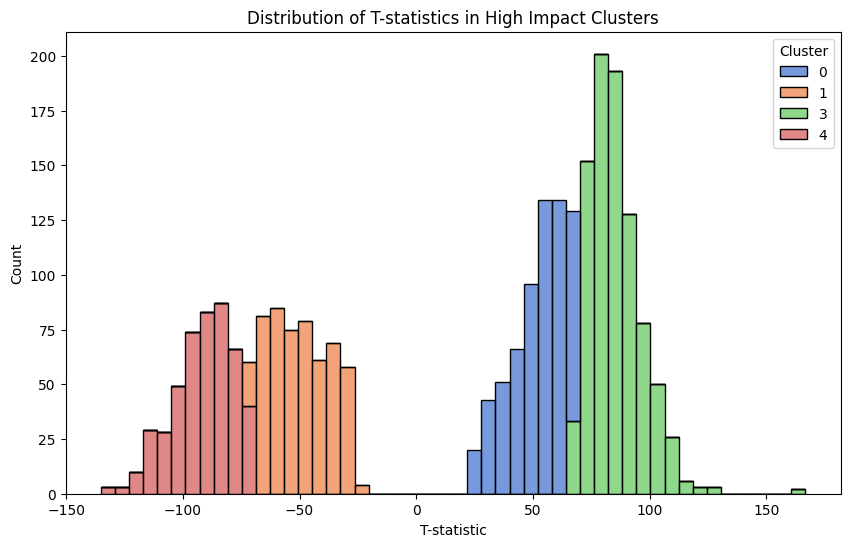

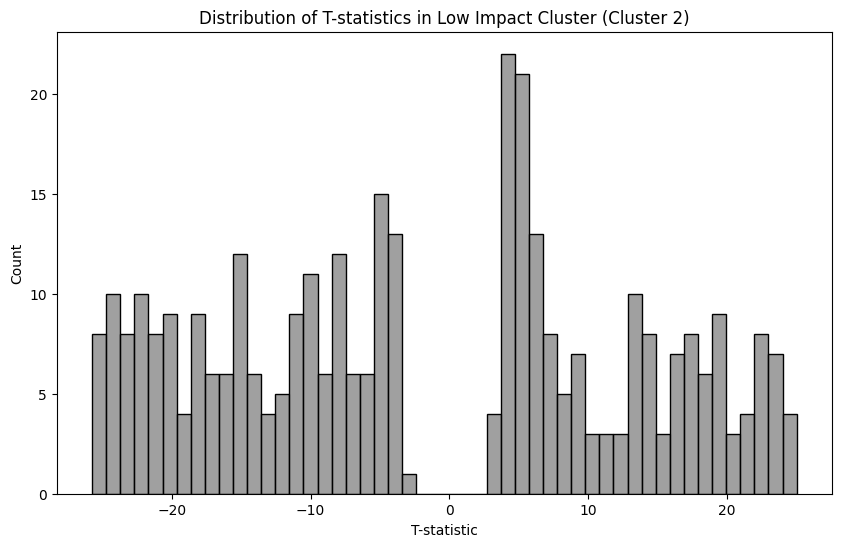

   Cluster  T_stat_mean  T_stat_std  T_stat_min  T_stat_max  T_stat_median  \
0        0    52.196850   11.492205   25.322382   68.772840      54.724369   
1        1   -49.643631   12.557775  -70.569810  -26.023668     -50.318305   
2        2    -1.705377   14.695414  -25.741505   25.028412      -3.848361   
3        3    85.380129   11.314633   68.849550  166.809590      83.617020   
4        4   -91.361252   12.901685 -135.126020  -70.729160     -89.569525   

   T_stat_25%  T_stat_75%  P_value_mean  P_value_std  P_value_min  \
0   44.048025   61.720116      0.000000     0.000000          0.0   
1  -60.579885  -38.596128      0.000000     0.000000          0.0   
2  -14.877956    9.444851      0.000022     0.000098          0.0   
3   77.246062   91.513177      0.000000     0.000000          0.0   
4  -99.295333  -81.706238      0.000000     0.000000          0.0   

   P_value_max  P_value_median  P_value_25%   P_value_75%  
0     0.000000    0.000000e+00          0.0  0.000000e+0

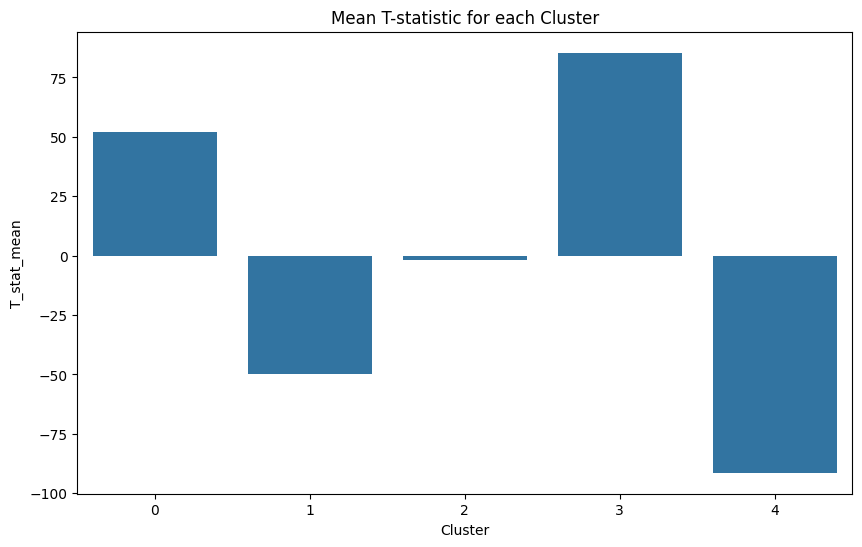

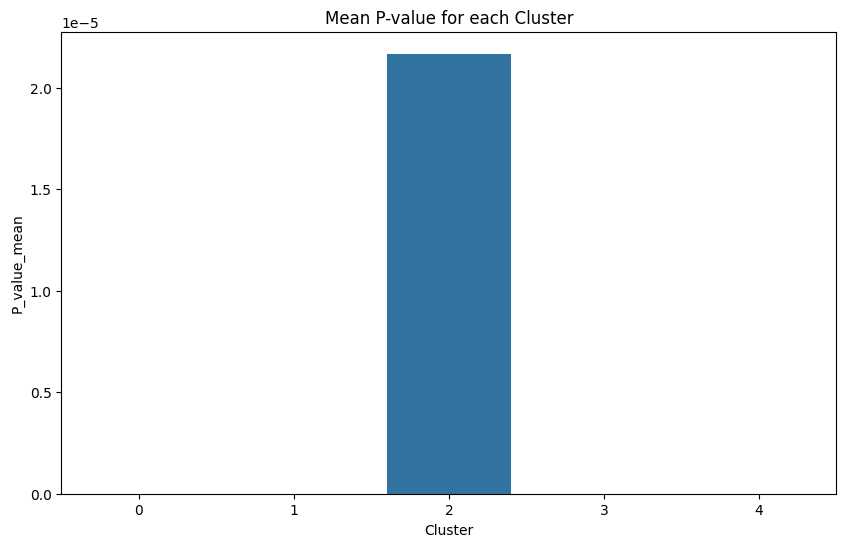

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'significant_features' dataframe contains the clustering results

# High-impact clusters
high_impact_clusters = significant_features[significant_features['Cluster'].isin([0, 1, 3, 4])]

# Visualize distribution of T-statistics in high impact clusters
plt.figure(figsize=(10, 6))
sns.histplot(data=high_impact_clusters, x='T-statistic', hue='Cluster', multiple='stack', bins=50, palette='muted')
plt.title('Distribution of T-statistics in High Impact Clusters')
plt.show()

# Low-impact cluster (Cluster 2)
low_impact_cluster = significant_features[significant_features['Cluster'] == 2]

# Visualize distribution of T-statistics in low impact cluster
plt.figure(figsize=(10, 6))
sns.histplot(data=low_impact_cluster, x='T-statistic', bins=50, color='gray')
plt.title('Distribution of T-statistics in Low Impact Cluster (Cluster 2)')
plt.show()

# Compare feature characteristics within and across clusters
# Create a summary statistics dataframe
summary_statistics = significant_features.groupby('Cluster').agg({
    'T-statistic': ['mean', 'std', 'min', 'max', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
    'P-value': ['mean', 'std', 'min', 'max', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
}).reset_index()

# Rename columns for clarity
summary_statistics.columns = ['Cluster', 'T_stat_mean', 'T_stat_std', 'T_stat_min', 'T_stat_max', 'T_stat_median', 'T_stat_25%', 'T_stat_75%',
                              'P_value_mean', 'P_value_std', 'P_value_min', 'P_value_max', 'P_value_median', 'P_value_25%', 'P_value_75%']

print(summary_statistics)

# Save the summary statistics to a CSV file
summary_statistics_csv_path = '/content/drive/MyDrive/KaggleData/summary_statistics.csv'
summary_statistics.to_csv(summary_statistics_csv_path, index=False)
print(f"Summary statistics CSV saved to {summary_statistics_csv_path}")

# Visualize summary statistics
# Mean T-statistic for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='T_stat_mean', data=summary_statistics)
plt.title('Mean T-statistic for each Cluster')
plt.show()

# Mean P-value for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='P_value_mean', data=summary_statistics)
plt.title('Mean P-value for each Cluster')
plt.show()


The mean P-values for these clusters are essentially zero. This indicates that the features within these clusters are highly statistically significant. The extremely low P-values mean that the features in these clusters strongly differentiate between classes and are very unlikely to have occurred by chance. The mean P-value for Cluster 2 is noticeably higher than the others (although still very small), around
2
×
1
0
−
5
2×10
−5
 . This indicates that the features in Cluster 2, while still significant, are less significant compared to the features in the other clusters.
This is consistent with the previous observation that Cluster 2 features have T-statistics close to zero, indicating they have less predictive power.


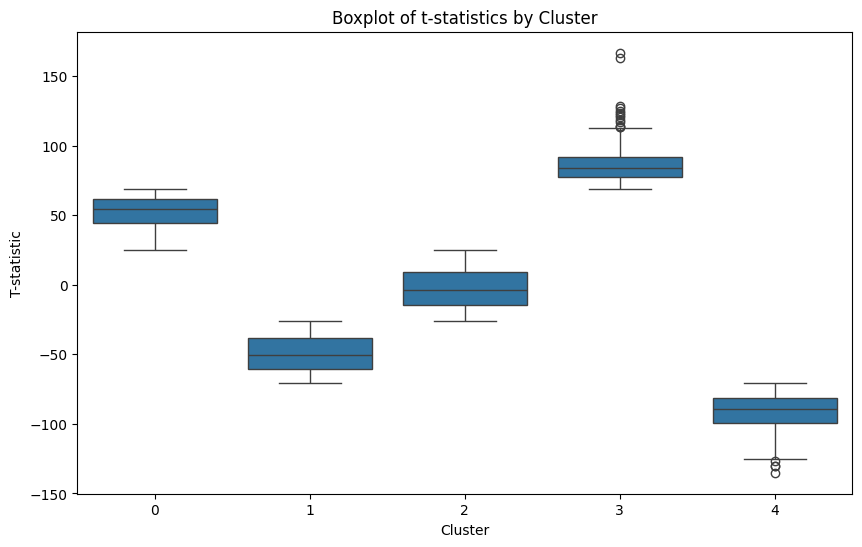

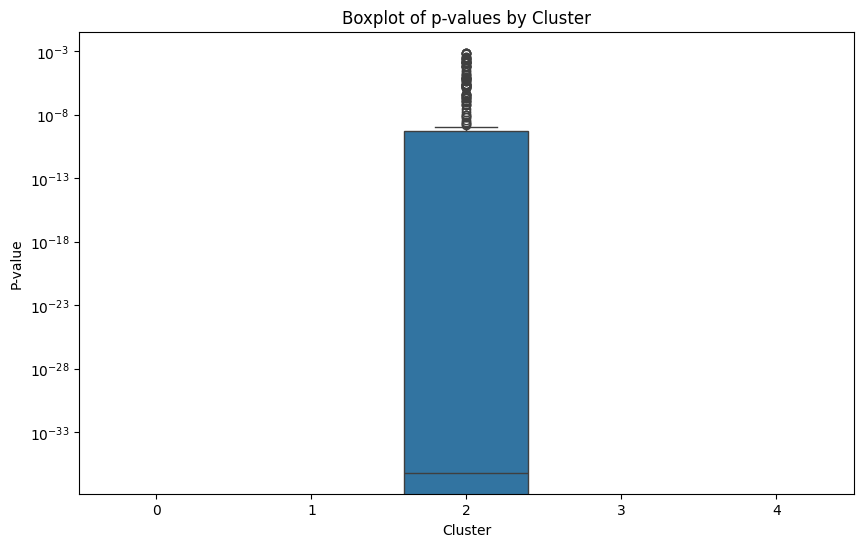

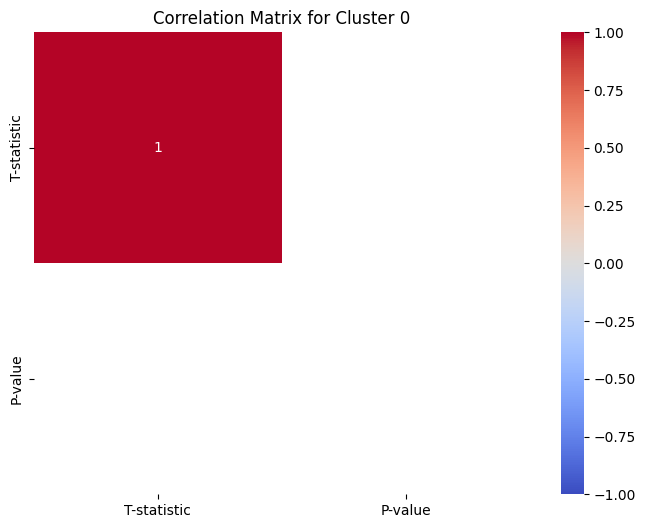

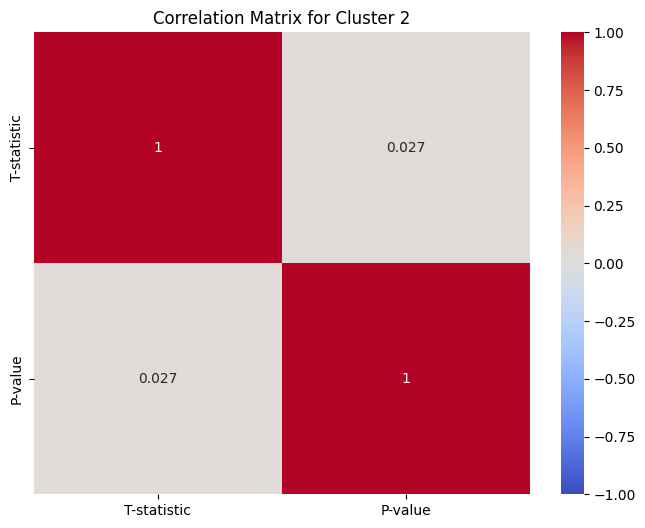

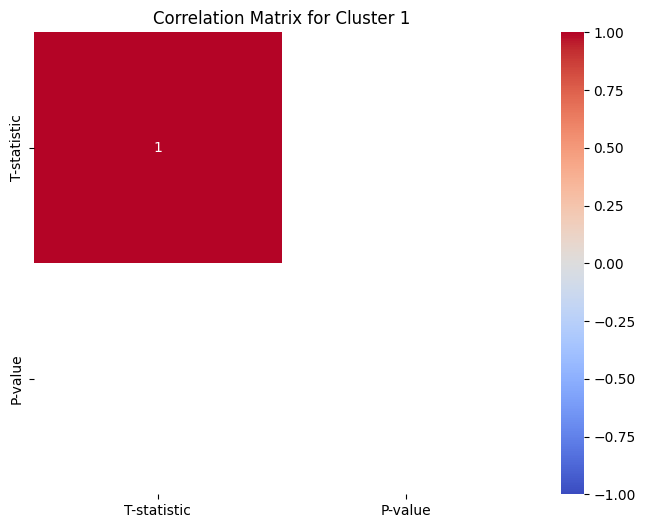

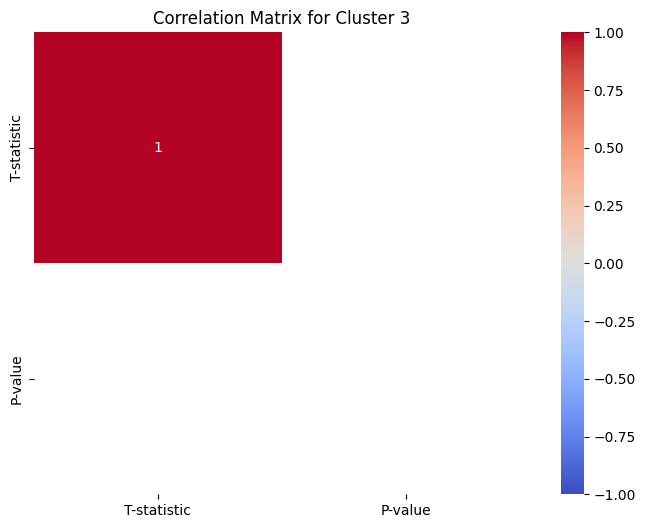

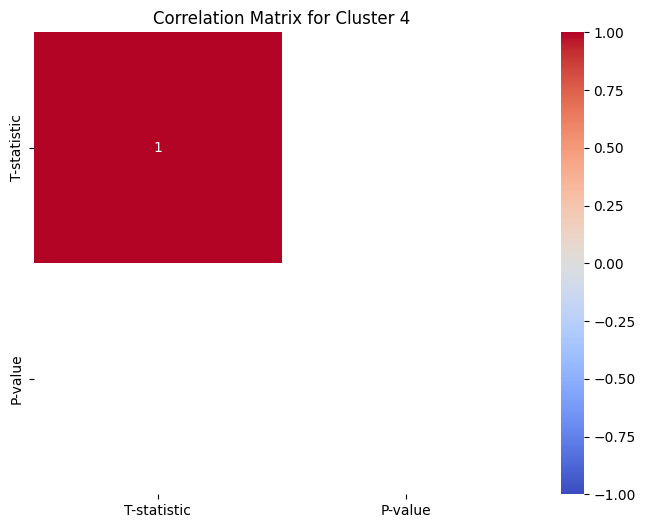

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plots for detailed comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='T-statistic', data=significant_features)
plt.title('Boxplot of t-statistics by Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='P-value', data=significant_features)
plt.title('Boxplot of p-values by Cluster')
plt.yscale('log')  # Log scale for better visualization of small P-values
plt.show()

# Feature correlation analysis within each cluster
for cluster in significant_features['Cluster'].unique():
    cluster_data = significant_features[significant_features['Cluster'] == cluster]
    correlation_matrix = cluster_data.drop(columns=['Model', 'Feature', 'Cluster']).corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Cluster {cluster}')
    plt.show()


# **VIT**

In [ ]:
# def build_vit_model():
#     vit_model = Sequential()
#     backbone = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))  # Replace with actual ViT import
#     vit_model.add(backbone)
#     vit_model.add(GlobalAveragePooling2D())  # Typically ViT uses pooling rather than flattening
#     vit_model.add(Dense(1024, activation='relu'))
#     vit_model.add(Dropout(0.5))
#     vit_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification
#     return vit_model

In [ ]:
# !pip install transformers


In [ ]:
def preprocess_images(images, image_processor):
    # Assuming images is a batch of images
    return image_processor(images=images, return_tensors="tf").pixel_values



# Sensitivity and Specificity metrics
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Custom weighted binary cross-entropy
def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1.0, weight_negative=1.0):
    y_true_float = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true_float, y_pred, from_logits=False)
    weight_vector = y_true_float * weight_positive + (1. - y_true_float) * weight_negative
    weighted_bce = weight_vector * bce
    return tf.reduce_mean(weighted_bce)

In [ ]:
from transformers import ViTImageProcessor
import numpy as np



def resize_image(image, size=(224, 224)):
    """Resizes an image to the specified size."""
    return tf.image.resize(image, size)

def preprocess_images(images, processor):
    """Converts a list of images to a batch of input tensors for ViT."""
    # Ensure all images are resized and formatted before processing
    images_resized = np.array([resize_image(image).numpy() for image in images])

    # Check if all images are the correct shape
    if images_resized.ndim != 4 or images_resized.shape[1:] != (224, 224, 3):
        raise ValueError("All images must be of shape (224, 224, 3).")

    # Process images with the processor, converting to tensors
    processed_images = processor(images=images_resized, return_tensors="tf").pixel_values
    return processed_images

In [ ]:
import numpy as np

# Load the full dataset
full_data_path = "/content/drive/MyDrive/KaggleData/ProcessedData/full_data.npy"
full_data = np.load(full_data_path, allow_pickle=True)

# Separate the images and labels
images = np.array([item[0] for item in full_data])
labels = np.array([item[1] for item in full_data])

print(f"Images shape: {images.shape}")  # This should show (7909, 224, 224, 3) or similar
print(f"Labels shape: {labels.shape}")  # This should show (7909,)

Images shape: (7909, 224, 224, 3)
Labels shape: (7909,)


In [ ]:
from transformers import ViTImageProcessor, TFAutoModelForImageClassification
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import numpy as np


def build_vit_model():
    # Load the ViT model pre-trained on ImageNet-21k
    vit_model = TFAutoModelForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k', num_labels=2)

    # Setup input layer
    input_layer = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32, name="input_image")

    # Since the model expects preprocessed inputs, ensure input_layer is used directly
    outputs = vit_model(input_layer).logits
    sigmoid_output = tf.keras.layers.Activation('sigmoid', name='sigmoid')(outputs)

    # Create and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=sigmoid_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
images = np.array([i[0] for i in full_data])  # Ensure these are RGB images
labels = np.array([i[1] for i in full_data])

# Preprocess images
X_train_processed = preprocess_images(images, image_processor)

# Now build and train the model
model = build_vit_model()
model.fit(X_train_processed, labels, epochs=12, batch_size=32)  # Assuming labels are correctly formatted


X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train_processed = preprocess_images(X_train, image_processor)

model = build_vit_model()
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
os.makedirs(model_save_dir, exist_ok=True)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

validation_scores = []
for train_index, val_index in kf.split(X_train_processed, Y_train):
    x_train_fold = X_train_processed[train_index]
    y_train_fold = Y_train[train_index]
    x_val_fold = X_train_processed[val_index]
    y_val_fold = Y_train[val_index]

    class_weights = {0: 1., 1: 1.}  # Modify based on class distribution

    vit_model, history = train_vit_model(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 12, model_save_dir, class_weights)
    val_loss, val_accuracy = vit_model.evaluate(x_val_fold, y_val_fold)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    validation_scores.append((val_loss, val_accuracy))

average_validation_scores = np.mean(validation_scores, axis=0)
print("Average Validation Scores:")
print(f"Loss: {average_validation_scores[0]}, Accuracy: {average_validation_scores[1]}")

history_path = os.path.join(model_save_dir, "vit_model_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

print(f"ViT Model and training history saved to {model_save_dir}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFViTPatchEmbeddings).

Make sure that the channel dimension of the pixel values match with the one set in the configuration.

Call arguments received by layer 'patch_embeddings' (type TFViTPatchEmbeddings):
  • pixel_values=<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_image')>
  • interpolate_pos_encoding=None
  • training=False

In [ ]:
from transformers import ViTImageProcessor, TFAutoModelForImageClassification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold

from transformers import ViTImageProcessor, TFAutoModelForImageClassification
import tensorflow as tf
import numpy as np

def preprocess_images(images, processor):
    # Ensure images are numpy arrays if not already
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    return processor(images=images, return_tensors="tf").pixel_values

def build_vit_model():
    vit_model = TFAutoModelForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k', num_labels=2)
    input_layer = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32, name="image")
    outputs = vit_model(input_layer).logits
    sigmoid_output = tf.keras.layers.Activation('sigmoid', name='sigmoid')(outputs)
    model = tf.keras.Model(inputs=input_layer, outputs=sigmoid_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def train_vit_model(model_function, x_train, y_train, x_val, y_val, epochs, model_save_dir, class_weights):
    vit_model = model_function()
    vit_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',  # Direct use of binary_crossentropy
        metrics=['accuracy', sensitivity, specificity, AUC(name='roc_auc')]
    )

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = datagen.flow(x_train, y_train, batch_size=16)
    val_generator = datagen.flow(x_val, y_val, batch_size=16, shuffle=False)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = vit_model.fit(
        train_generator,
        steps_per_epoch=len(x_train) // 16,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(x_val) // 16,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr]
    )

    vit_model.save(os.path.join(model_save_dir, "vit_model.h5"))
    return vit_model, history

# Define your preprocessed dataset
images = np.array([i[0] for i in full_data])
labels = np.array([i[1] for i in full_data])

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the number of splits for cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize list to store validation scores
validation_scores = []

# Create a new folder for cross-validation results
model_save_dir = "/content/drive/MyDrive/KaggleData/CrossValidationResults"
os.makedirs(model_save_dir, exist_ok=True)

# Loop over each fold
for train_index, val_index in kf.split(X_train, Y_train):
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

    # Class weights for imbalanced data
    total_samples = len(y_train_fold)
    class_counts = np.unique(y_train_fold, return_counts=True)[1]
    weight_for_0 = total_samples / (2 * class_counts[0])
    weight_for_1 = total_samples / (2 * class_counts[1])
    class_weights = {0: weight_for_0, 1: weight_for_1}

    # Train the model
    vit_model, history = train_vit_model(build_vit_model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 12, model_save_dir, class_weights)

    # Evaluate the model on validation data
    val_loss, val_accuracy, val_sensitivity, val_specificity, val_auc = vit_model.evaluate(x_val_fold, y_val_fold)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Sensitivity: {val_sensitivity}')
    print(f'Validation Specificity: {val_specificity}')
    print(f'Validation AUC: {val_auc}')

    # Store validation scores
    validation_scores.append((val_loss, val_accuracy, val_sensitivity, val_specificity, val_auc))

# Calculate average validation scores across folds
average_validation_scores = np.mean(validation_scores, axis=0)
print("Average Validation Scores:")
print(f"Loss: {average_validation_scores[0]}")
print(f"Accuracy: {average_validation_scores[1]}")
print(f"Sensitivity: {average_validation_scores[2]}")
print(f"Specificity: {average_validation_scores[3]}")
print(f"AUC: {average_validation_scores[4]}")


# Save model and training history
model_path = os.path.join(model_save_dir, "vit_model.h5")  # Ensure the correct model name here
vit_model.save(model_path)  # Make sure to use the correct variable (vit_model)

history_path = os.path.join(model_save_dir, "vit_model_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)  # Ensure using the correct history variable

print(f"ViT Model and training history saved to {model_save_dir}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFViTPatchEmbeddings).

Make sure that the channel dimension of the pixel values match with the one set in the configuration.

Call arguments received by layer 'patch_embeddings' (type TFViTPatchEmbeddings):
  • pixel_values=<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'image')>
  • interpolate_pos_encoding=None
  • training=False